In [1]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('fivethirtyeight')

# Modelado
# ==============================================================================
from sklearn.datasets import make_blobs
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
import multiprocessing

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

## Datos de entrada

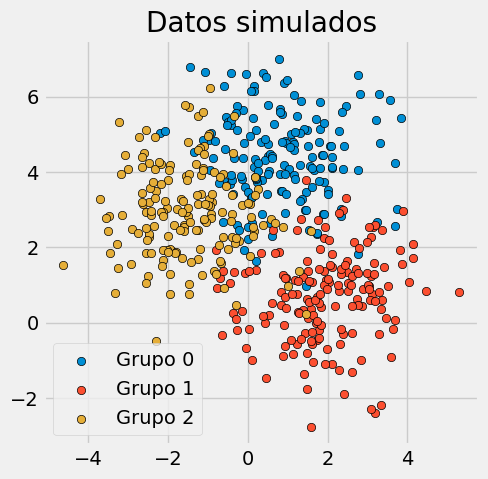

In [2]:
# Datos simulados
# ==============================================================================
X, y = make_blobs(
        n_samples    = 500, 
        n_features   = 2, 
        centers      = 3, 
        cluster_std  = 1.2, 
        shuffle      = True, 
        random_state = 0
       )

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
for i in np.unique(y):
    ax.scatter(
        x = X[y == i, 0],
        y = X[y == i, 1], 
        c = plt.rcParams['axes.prop_cycle'].by_key()['color'][i],
        marker    = 'o',
        edgecolor = 'black', 
        label= f"Grupo {i}"
    )
    
ax.set_title('Datos simulados')
ax.legend();

## Creación de 4 modelos diferentes para ver la capacidad de aprendizaje

In [3]:
# Modelos
# ==============================================================================
modelo_1 = MLPClassifier(
                hidden_layer_sizes=(5), #1 capa oculta formada por 5 neuronas
                learning_rate_init=0.01, #valor incial de la rapidez en la que 
                                         #cambian los parámetros de un modelo 
                                         #cada vez que aprende
                solver = 'lbfgs', #algoritmo de optimización
                max_iter = 1000, #número de máximas iteraciones
                random_state = 123 #semilla 
            )

modelo_2 = MLPClassifier(
                hidden_layer_sizes=(10), 
                learning_rate_init=0.01,
                solver = 'lbfgs',
                max_iter = 1000,
                random_state = 123
            )

modelo_3 = MLPClassifier(
                hidden_layer_sizes=(20, 20),
                learning_rate_init=0.01,
                solver = 'lbfgs',
                max_iter = 5000,
                random_state = 123
            )

modelo_4 = MLPClassifier(
                hidden_layer_sizes=(50, 50, 50),
                learning_rate_init=0.01,
                solver = 'lbfgs',
                max_iter = 5000,
                random_state = 123
            )

modelo_1.fit(X=X, y=y)
modelo_2.fit(X=X, y=y)
modelo_3.fit(X=X, y=y)
modelo_4.fit(X=X, y=y)

MLPClassifier(hidden_layer_sizes=(50, 50, 50), learning_rate_init=0.01,
              max_iter=5000, random_state=123, solver='lbfgs')

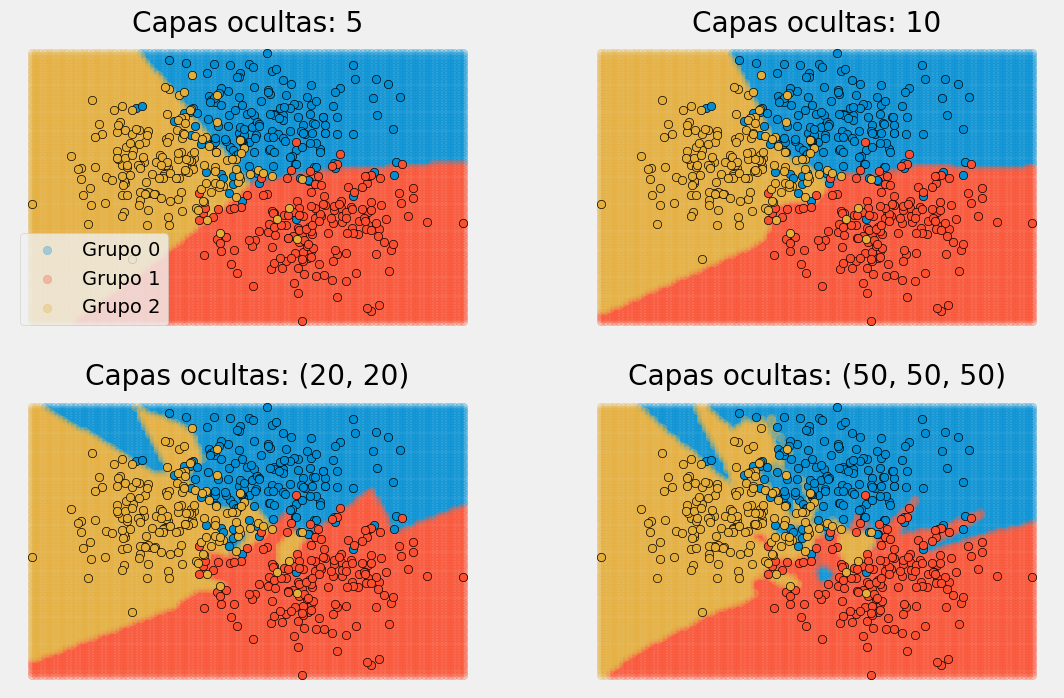

In [4]:
# Gráfico de predicciones
# ==============================================================================
fig, axs = plt.subplots(2, 2, figsize=(12,8))
axs = axs.flatten()
grid_x1 = np.linspace(start=min(X[:, 0]), stop=max(X[:, 0]), num=100)
grid_x2 = np.linspace(start=min(X[:, 1]), stop=max(X[:, 1]), num=100)
xx, yy = np.meshgrid(grid_x1, grid_x2)
X_grid = np.column_stack([xx.flatten(), yy.flatten()])

for i, modelo in enumerate([modelo_1, modelo_2, modelo_3, modelo_4]):
    
    predicciones = modelo.predict(X_grid)
    
    for j in np.unique(predicciones):
        axs[i].scatter(
            x = X_grid[predicciones == j, 0],
            y = X_grid[predicciones == j, 1], 
            c = plt.rcParams['axes.prop_cycle'].by_key()['color'][j],
            #marker = 'o',
            alpha = 0.3,
            label= f"Grupo {j}"
        )

    for j in np.unique(y):
        axs[i].scatter(
            x = X[y == j, 0],
            y = X[y == j, 1], 
            c = plt.rcParams['axes.prop_cycle'].by_key()['color'][j],
            marker    = 'o',
            edgecolor = 'black'
        )
        
    axs[i].set_title(f"Capas ocultas: {modelo.hidden_layer_sizes}")
    axs[i].axis('off')
axs[0].legend();

A medida que aumenta la complejidad de la red (más neuronas y más capas), las fronteras de decisión se adaptan más y más a los datos de entrenamiento.

## Optimización de hiperparámetros

In [5]:
# Número de neuronas
# ==============================================================================
param_grid = {'hidden_layer_sizes':[1, 5, 10, 15, 25, 50]} #6 capas ocultas con sus neuronas

grid = GridSearchCV(
        estimator = MLPClassifier(
                        learning_rate_init=0.01,
                        solver = 'lbfgs',
                        alpha  = 0,
                        max_iter = 5000,
                        random_state = 123
                    ),
        param_grid = param_grid,
        scoring    = 'accuracy',
        cv         = 5,
        refit      = True,
        return_train_score = True
      )

_ = grid.fit(X, y)

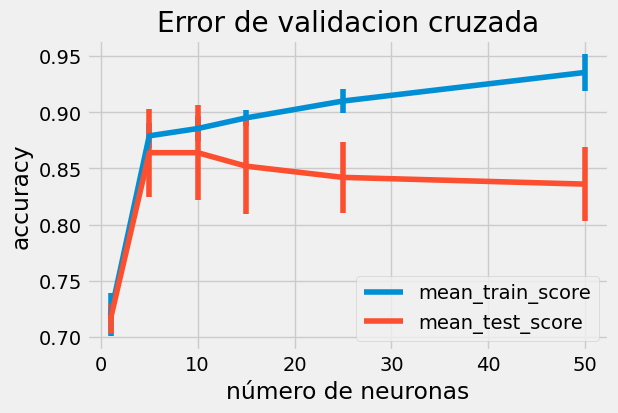

In [6]:
fig, ax = plt.subplots(figsize=(6, 3.84))
scores = pd.DataFrame(grid.cv_results_)
scores.plot(x='param_hidden_layer_sizes', y='mean_train_score', yerr='std_train_score', ax=ax)
scores.plot(x='param_hidden_layer_sizes', y='mean_test_score', yerr='std_test_score', ax=ax)
ax.set_ylabel('accuracy')
ax.set_xlabel('número de neuronas')
ax.set_title('Error de validacion cruzada');

In [7]:
# learning rate
# ==============================================================================
param_grid = {'learning_rate_init':[0.0001, 0.001, 0.01, 0.1, 1, 10, 100]}

grid = GridSearchCV(
        estimator = MLPClassifier(
                        hidden_layer_sizes=(10),
                        solver = 'adam',
                        alpha  = 0,
                        max_iter = 5000,
                        random_state = 123
                    ),
        param_grid = param_grid,
        scoring    = 'accuracy',
        cv         = 5,
        refit      = True,
        return_train_score = True
      )

_ = grid.fit(X, y)

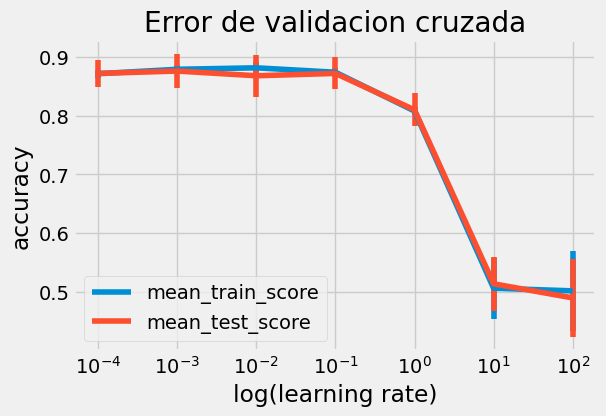

In [8]:
fig, ax = plt.subplots(figsize=(6, 3.84))
scores = pd.DataFrame(grid.cv_results_)
scores.plot(x='param_learning_rate_init', y='mean_train_score', yerr='std_train_score', ax=ax)
scores.plot(x='param_learning_rate_init', y='mean_test_score', yerr='std_test_score', ax=ax)
ax.set_xscale('log')
ax.set_xlabel('log(learning rate)')
ax.set_ylabel('accuracy')
ax.set_title('Error de validacion cruzada');

In [9]:
# Espacio de búsqueda de cada hiperparámetro
# ==============================================================================
param_distributions = {
    'hidden_layer_sizes': [(10), (10, 10), (20, 20)],
    'alpha': np.logspace(-3, 3, 7),
    'learning_rate_init': [0.001, 0.01, 0.1],
}

# Búsqueda por validación cruzada
# ==============================================================================
grid = RandomizedSearchCV(
        estimator  = MLPClassifier(solver = 'lbfgs', max_iter= 2000),
        param_distributions = param_distributions,
        n_iter     = 100, # Número máximo de combinaciones probadas
        scoring    = 'accuracy',
        n_jobs     = multiprocessing.cpu_count() - 1,
        cv         = 3, 
        verbose    = 0,
        random_state = 123,
        return_train_score = True
       )

grid.fit(X = X, y = y)

# Resultados del grid
# ==============================================================================
resultados = pd.DataFrame(grid.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)')\
    .drop(columns = 'params')\
    .sort_values('mean_test_score', ascending = False)\
    .head(10)

/home/pgregorio/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/pgregorio/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/home/pgregorio/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:545: ConvergenceWarning: lbfgs failed to converge (status

,param_learning_rate_init,param_hidden_layer_sizes,param_alpha,mean_test_score,std_test_score,mean_train_score,std_train_score
47,0.100,10,100.0,0.869899,0.042016,0.873973,0.021077
46,0.010,10,100.0,0.869899,0.042016,0.873973,0.021077
45,0.001,10,100.0,0.869899,0.042016,0.873973,0.021077
31,0.010,"(10, 10)",1.0,0.867903,0.048513,0.894976,0.027919
32,0.100,"(10, 10)",1.0,0.867891,0.050026,0.903967,0.031371
38,0.100,10,10.0,0.865919,0.037716,0.877977,0.022883
36,0.001,10,10.0,0.865919,0.037716,0.876979,0.021892
37,0.010,10,10.0,0.865919,0.034747,0.875978,0.021527
40,0.010,"(10, 10)",10.0,0.865919,0.041054,0.879979,0.021889
43,0.010,"(20, 20)",10.0,0.865919,0.037716,0.876976,0.022578


La combinación de hiperparámetros que mejores resultados consigue es:

In [10]:
modelo = grid.best_estimator_
modelo

MLPClassifier(alpha=100.0, hidden_layer_sizes=10, max_iter=2000, solver='lbfgs')

Ahora el modelo ya está entrenado

In [11]:
grid_x1 = np.linspace(start=min(X[:, 0]), stop=max(X[:, 0]), num=100)
grid_x2 = np.linspace(start=min(X[:, 1]), stop=max(X[:, 1]), num=100)
xx, yy = np.meshgrid(grid_x1, grid_x2)

X_grid = np.column_stack([xx.flatten(), yy.flatten()])
predicciones = modelo.predict(X_grid)

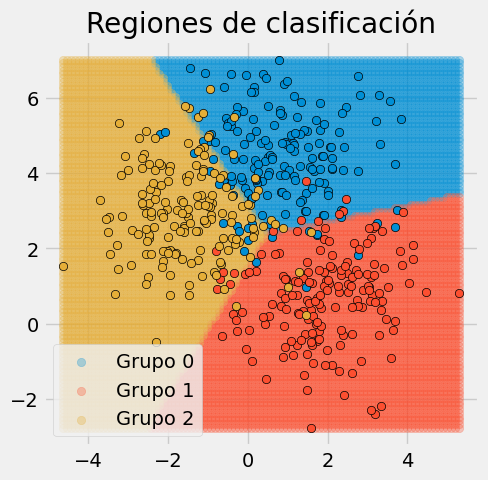

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))

for i in np.unique(predicciones):
    ax.scatter(
        x = X_grid[predicciones == i, 0],
        y = X_grid[predicciones == i, 1], 
        c = plt.rcParams['axes.prop_cycle'].by_key()['color'][i],
        #marker = 'o',
        alpha = 0.3,
        label= f"Grupo {i}"
    )

for i in np.unique(y):
    ax.scatter(
        x = X[y == i, 0],
        y = X[y == i, 1], 
        c = plt.rcParams['axes.prop_cycle'].by_key()['color'][i],
        marker    = 'o',
        edgecolor = 'black'
    )
    

ax.set_title('Regiones de clasificación')
ax.legend();

## Caso de uso: predicción de precios vivienda

El objetivo es obtener un modelo capaz de predecir el precio del alquiler.

In [13]:
# Tratamiento de datos
# ==============================================================================
import numpy as np
import pandas as pd

# Gráficos
# ==============================================================================
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('fivethirtyeight')

# Modelado
# ==============================================================================
from sklearn.neural_network import MLPRegressor
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_selector
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import KFold
from sklearn import set_config
import multiprocessing

# Configuración warnings
# ==============================================================================
import warnings
warnings.filterwarnings('ignore')

In [14]:
# Descarga de datos
# ==============================================================================
url = ("https://raw.githubusercontent.com/JoaquinAmatRodrigo/"
       "Estadistica-machine-learning-python/master/data/SaratogaHouses.csv")
datos = pd.read_csv(url, sep=",")

# Se renombran las columnas para que sean más descriptivas
datos.columns = ["precio", "metros_totales", "antiguedad", "precio_terreno",
                 "metros_habitables", "universitarios", "dormitorios", 
                 "chimenea", "banyos", "habitaciones", "calefaccion",
                 "consumo_calefacion", "desague", "vistas_lago",
                 "nueva_construccion", "aire_acondicionado"]

Se comprueba que todas las columnas tienen el tipo correcto

In [15]:
# Tipo de cada columna
# ==============================================================================
# En pandas, el tipo "object" hace referencia a strings
datos.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1728 entries, 0 to 1727
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   precio              1728 non-null   int64  
 1   metros_totales      1728 non-null   float64
 2   antiguedad          1728 non-null   int64  
 3   precio_terreno      1728 non-null   int64  
 4   metros_habitables   1728 non-null   int64  
 5   universitarios      1728 non-null   int64  
 6   dormitorios         1728 non-null   int64  
 7   chimenea            1728 non-null   int64  
 8   banyos              1728 non-null   float64
 9   habitaciones        1728 non-null   int64  
 10  calefaccion         1728 non-null   object 
 11  consumo_calefacion  1728 non-null   object 
 12  desague             1728 non-null   object 
 13  vistas_lago         1728 non-null   object 
 14  nueva_construccion  1728 non-null   object 
 15  aire_acondicionado  1728 non-null   object 
dtypes: flo

In [16]:
# Comprobación del número de datos ausentes por variable
# ==============================================================================
datos.isna().sum().sort_values()

precio                0
metros_totales        0
antiguedad            0
precio_terreno        0
metros_habitables     0
universitarios        0
dormitorios           0
chimenea              0
banyos                0
habitaciones          0
calefaccion           0
consumo_calefacion    0
desague               0
vistas_lago           0
nueva_construccion    0
aire_acondicionado    0
dtype: int64

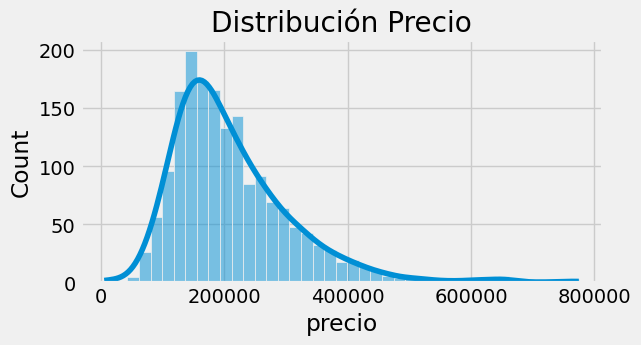

In [17]:
# Distribución variable respuesta
# ==============================================================================
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 3))
sns.histplot(data=datos, x='precio', kde=True,ax=ax)
ax.set_title("Distribución Precio")
ax.set_xlabel('precio');

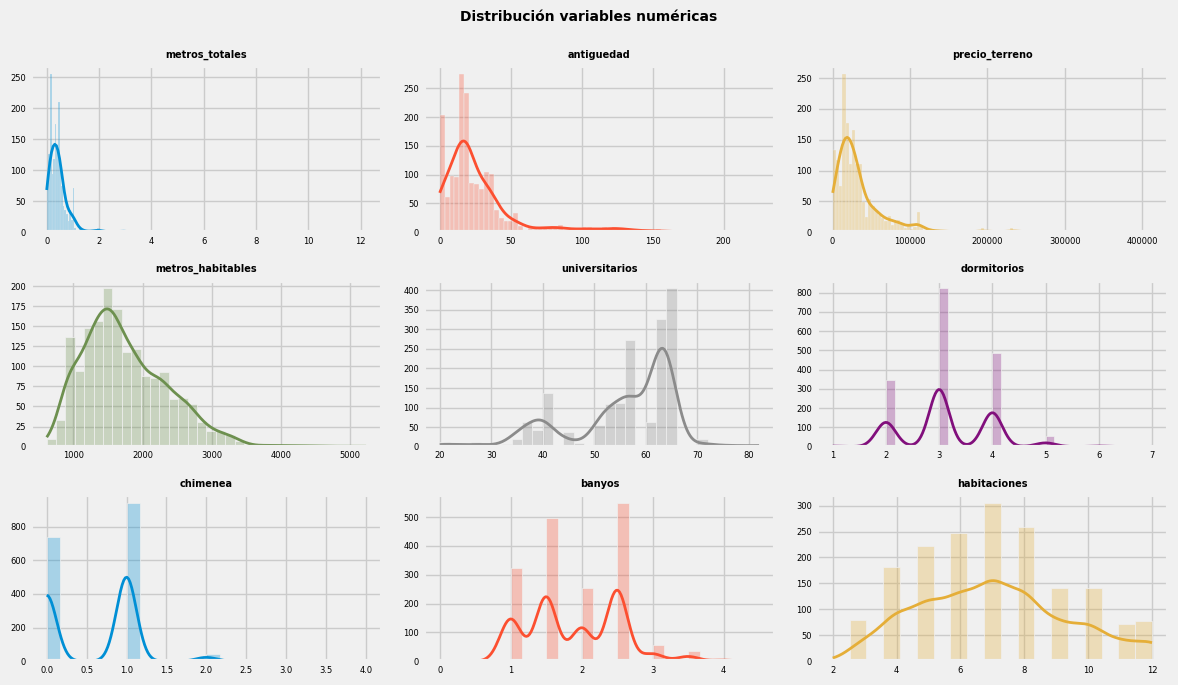

In [18]:
# Gráfico de distribución para cada variable numérica
# ==============================================================================
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12, 7))
axes = axes.flat
columnas_numeric = datos.select_dtypes(include=['float64', 'int']).columns
columnas_numeric = columnas_numeric.drop('precio')

for i, colum in enumerate(columnas_numeric):
    sns.histplot(
        data    = datos,
        x       = colum,
        stat    = "count",
        kde     = True,
        color   = (list(plt.rcParams['axes.prop_cycle'])*2)[i]["color"],
        line_kws= {'linewidth': 2},
        alpha   = 0.3,
        ax      = axes[i]
    )
    axes[i].set_title(colum, fontsize = 7, fontweight = "bold")
    axes[i].tick_params(labelsize = 6)
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")
    
    
fig.tight_layout()
plt.subplots_adjust(top = 0.9)
fig.suptitle('Distribución variables numéricas', fontsize = 10, fontweight = "bold");

La variable chimenea, aunque es de tipo numérico, apenas toma unos pocos valores y la gran mayoría de observaciones pertenecen a solo dos de ellos. En casos como este, suele ser conveniente tratar la variable como cualitativa.

In [19]:
# Valores observados de chimenea
# ==============================================================================
datos.chimenea = datos.chimenea.astype("str")
datos.chimenea.value_counts()

chimenea
1    942
0    740
2     42
4      2
3      2
Name: count, dtype: int64

In [20]:
# Variables cualitativas (tipo object)
# ==============================================================================
datos.select_dtypes(include=['object']).describe()

,chimenea,calefaccion,consumo_calefacion,desague,vistas_lago,nueva_construccion,aire_acondicionado
count,1728,1728,1728,1728,1728,1728,1728
unique,5,3,3,3,2,2,2
top,1,hot air,gas,public/commercial,No,No,No
freq,942,1121,1197,1213,1713,1647,1093


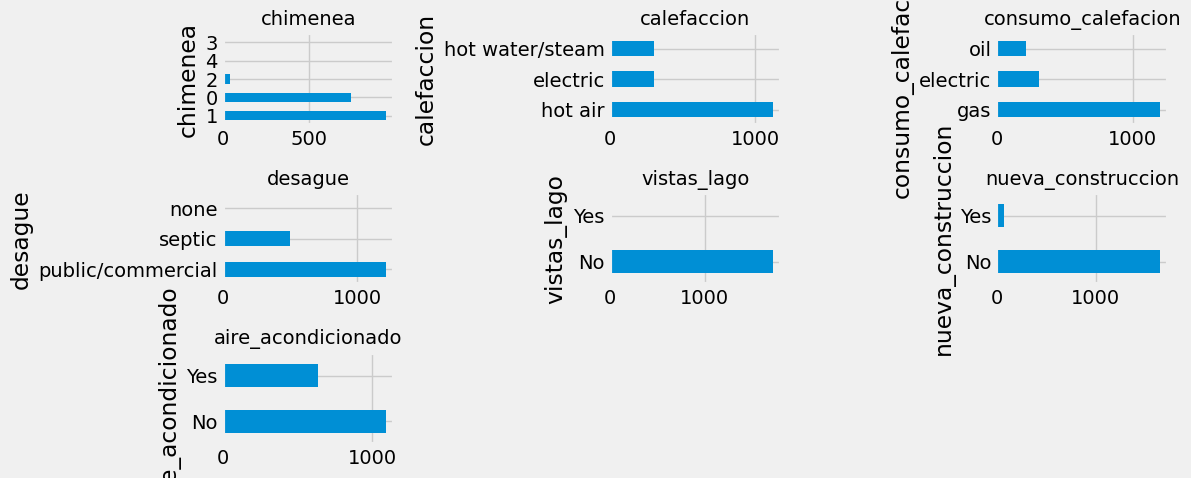

In [21]:
# Gráfico para cada variable cualitativa
# ==============================================================================
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12, 5))
axes = axes.flat
columnas_object = datos.select_dtypes(include=['object']).columns

for i, colum in enumerate(columnas_object):
    datos[colum].value_counts().plot.barh(ax = axes[i])
    axes[i].set_title(colum, fontsize = 14)
    axes[i].set_xlabel("")

# Se eliminan los axes vacíos
for i in [7, 8]:
    fig.delaxes(axes[i])
    
fig.tight_layout()

Si alguno de los niveles de una variable cualitativa tiene muy pocas observaciones en comparación a los otros niveles, puede ocurrir que, durante la validación cruzada o bootstrapping, algunas particiones no contengan ninguna observación de dicha clase (varianza cero), lo que puede dar lugar a errores. Para este caso, hay que tener precaución con la variable chimenea. Se unifican los niveles de 2, 3 y 4 en un nuevo nivel llamado "2_mas".

In [22]:
dic_replace = {'2': "2_mas",
               '3': "2_mas",
               '4': "2_mas"}

datos['chimenea'] = datos['chimenea'] \
                     .map(dic_replace) \
                     .fillna(datos['chimenea'])
datos.chimenea.value_counts().sort_index()

chimenea
0        740
1        942
2_mas     46
Name: count, dtype: int64

## División train y test

In [23]:
# Reparto de datos en train y test
# ==============================================================================
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
                                        datos.drop('precio', axis = 'columns'),
                                        datos['precio'],
                                        train_size   = 0.8,
                                        random_state = 1234,
                                        shuffle      = True
                                    )

Se verifica que los datos están bien repartidos:

In [24]:
print("Partición de entrenamento")
print("-----------------------")
display(y_train.describe())
display(X_train.describe())
display(X_train.describe(include = 'object'))
print(" ")

print("Partición de test")
print("-----------------------")
display(y_test.describe())
display(X_test.describe())
display(X_test.describe(include = 'object'))

Partición de entrenamento
-----------------------


count      1382.000000
mean     211436.516643
std       96846.639129
min       10300.000000
25%      145625.000000
50%      190000.000000
75%      255000.000000
max      775000.000000
Name: precio, dtype: float64

,metros_totales,antiguedad,precio_terreno,metros_habitables,universitarios,dormitorios,banyos,habitaciones
count,1382.000000,1382.000000,1382.000000,1382.000000,1382.000000,1382.000000,1382.000000,1382.000000
mean,0.501331,27.494211,34232.141823,1755.940666,55.439942,3.165702,1.902677,7.073082
std,0.671766,28.212721,35022.662319,621.262215,10.356656,0.825487,0.660053,2.315395
min,0.000000,0.000000,200.000000,616.000000,20.000000,1.000000,0.000000,2.000000
25%,0.170000,13.000000,15100.000000,1302.000000,52.000000,3.000000,1.500000,5.000000
50%,0.370000,19.000000,25000.000000,1650.000000,57.000000,3.000000,2.000000,7.000000
75%,0.540000,33.750000,39200.000000,2127.250000,63.000000,4.000000,2.500000,9.000000
max,8.970000,201.000000,412600.000000,4856.000000,82.000000,7.000000,4.500000,12.000000


,chimenea,calefaccion,consumo_calefacion,desague,vistas_lago,nueva_construccion,aire_acondicionado
count,1382,1382,1382,1382,1382,1382,1382
unique,3,3,3,3,2,2,2
top,1,hot air,gas,public/commercial,No,No,No
freq,741,915,972,970,1370,1321,863


 
Partición de test
-----------------------


count       346.000000
mean     214084.395954
std      104689.155889
min        5000.000000
25%      139000.000000
50%      180750.000000
75%      271750.000000
max      670000.000000
Name: precio, dtype: float64

,metros_totales,antiguedad,precio_terreno,metros_habitables,universitarios,dormitorios,banyos,habitaciones
count,346.000000,346.000000,346.000000,346.000000,346.000000,346.000000,346.000000,346.000000
mean,0.495751,29.601156,35855.491329,1751.121387,56.078035,3.109827,1.890173,6.916185
std,0.798240,32.884116,35035.761216,615.486848,10.239861,0.783575,0.652368,2.319776
min,0.010000,0.000000,300.000000,792.000000,20.000000,1.000000,1.000000,2.000000
25%,0.160000,13.000000,15100.000000,1296.000000,52.000000,3.000000,1.500000,5.000000
50%,0.370000,19.000000,26700.000000,1608.000000,57.000000,3.000000,2.000000,7.000000
75%,0.557500,34.000000,45950.000000,2181.000000,64.000000,4.000000,2.500000,8.000000
max,12.200000,225.000000,233000.000000,5228.000000,82.000000,6.000000,4.000000,12.000000


,chimenea,calefaccion,consumo_calefacion,desague,vistas_lago,nueva_construccion,aire_acondicionado
count,346,346,346,346,346,346,346
unique,3,3,3,3,2,2,2
top,1,hot air,gas,public/commercial,No,No,No
freq,201,206,225,243,343,326,230


## Preprocesado

In [25]:
# Selección de las variables por típo
# ==============================================================================
# Se estandarizan las columnas numéricas y se hace one-hot-encoding de las 
# columnas cualitativas. Para mantener las columnas a las que no se les aplica 
# ninguna transformación se tiene que indicar remainder='passthrough'.

# Identificación de columnas numéricas y categóricas
numeric_cols = X_train.select_dtypes(include=['float64', 'int']).columns.to_list()
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.to_list()


# Transformaciones para las variables numéricas
numeric_transformer = Pipeline(
                        steps=[('scaler', StandardScaler())]
                      )

# Transformaciones para las variables categóricas
categorical_transformer = Pipeline(
                            steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))]
                          )

preprocessor = ColumnTransformer(
                    transformers=[
                        ('numeric', numeric_transformer, numeric_cols),
                        ('cat', categorical_transformer, cat_cols)
                    ],
                    remainder='passthrough'
                )

In [26]:
set_config(display='diagram')
preprocessor

ColumnTransformer(remainder='passthrough',
                  transformers=[('numeric',
                                 Pipeline(steps=[('scaler', StandardScaler())]),
                                 ['metros_totales', 'antiguedad',
                                  'precio_terreno', 'metros_habitables',
                                  'universitarios', 'dormitorios', 'banyos',
                                  'habitaciones']),
                                ('cat',
                                 Pipeline(steps=[('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['chimenea', 'calefaccion',
                                  'consumo_calefacion', 'desague',
                                  'vistas_lago', 'nueva_construccion',
                                  'aire_acondicionado'])])

In [27]:
set_config(display='text')

In [28]:
# Se aprenden y aplican las transformaciones de preprocesado
# ==============================================================================
X_train_prep = preprocessor.fit_transform(X_train)
X_test_prep  = preprocessor.transform(X_test)

In [29]:
# Convertir el output en dataframe y añadir el nombre de las columnas
# ==============================================================================
encoded_cat = preprocessor.named_transformers_['cat']['onehot']\
              .get_feature_names(cat_cols)
labels = np.concatenate([numeric_cols, encoded_cat])
datos_train_prep = preprocessor.transform(X_train)
datos_train_prep = pd.DataFrame(datos_train_prep, columns=labels)
datos_train_prep.info() # Convertir el output en dataframe y añadir el nombre de las columnas
# ==============================================================================
encoded_cat = preprocessor.named_transformers_['cat']['onehot']\
              .get_feature_names(cat_cols)
labels = np.concatenate([numeric_cols, encoded_cat])
datos_train_prep = preprocessor.transform(X_train)
datos_train_prep = pd.DataFrame(datos_train_prep, columns=labels)
datos_train_prep.info()

AttributeError: 'OneHotEncoder' object has no attribute 'get_feature_names'

In [ ]:
# Pipeline de preprocedado y modelado
# ==============================================================================

# Identificación de columnas numéricas y categóricas
numeric_cols = X_train.select_dtypes(include=['float64', 'int']).columns.to_list()
cat_cols = X_train.select_dtypes(include=['object', 'category']).columns.to_list()


# Transformaciones para las variables numéricas
numeric_transformer = Pipeline(
                        steps=[('scaler', StandardScaler())]
                      )

# Transformaciones para las variables categóricas
categorical_transformer = Pipeline(
                            steps=[('onehot', OneHotEncoder(handle_unknown='ignore'))]
                          )

preprocessor = ColumnTransformer(
                    transformers=[
                        ('numeric', numeric_transformer, numeric_cols),
                        ('cat', categorical_transformer, cat_cols)
                    ],
                    remainder='passthrough'
                )

# Se combinan los pasos de preprocesado y el modelo en un mismo pipeline
pipe = Pipeline([('preprocessing', preprocessor),
                 ('modelo', MLPRegressor(solver = 'lbfgs', max_iter= 1000))])

In [ ]:
# Espacio de búsqueda de cada hiperparámetro
# ==============================================================================
param_distributions = {
    'modelo__hidden_layer_sizes': [(10), (20), (10, 10)],
    'modelo__alpha': np.logspace(-3, 3, 10),
    'modelo__learning_rate_init': [0.001, 0.01],
}

# Búsqueda por validación cruzada
# ==============================================================================
grid = RandomizedSearchCV(
        estimator  = pipe,
        param_distributions = param_distributions,
        n_iter     = 50,
        scoring    = 'neg_mean_squared_error',
        n_jobs     = multiprocessing.cpu_count() - 1,
        cv         = 5, 
        verbose    = 0,
        random_state = 123,
        return_train_score = True
       )

grid.fit(X = X_train, y = y_train)

# Resultados del grid
# ==============================================================================
resultados = pd.DataFrame(grid.cv_results_)
resultados.filter(regex = '(param.*|mean_t|std_t)')\
    .drop(columns = 'params')\
    .sort_values('mean_test_score', ascending = False)\
    .head(10)

In [ ]:
# Error de test
# ==============================================================================
modelo_final = grid.best_estimator_
predicciones = modelo_final.predict(X = X_test)
rmse = mean_squared_error(
        y_true = y_test,
        y_pred = predicciones,
        squared = False
       )
print('Error de test (rmse): ', rmse)

In [ ]:
modelo_final['modelo'].get_params()